In [1]:
import sys
sys.path.append("../src")

import logging
from pathlib import Path
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci, unnormalize_depth
import yaml

root_path = Path("../")

class Args:
    model_dir = root_path / "resources/models/1645352053.680582/M_total"

args = Args()

config_path = args.model_dir.parent / "config.yml"
model = sorted(args.model_dir.glob("*.pth"))[-1]
with open(config_path) as f:
    config = yaml.safe_load(f)

network_config = config['network_config']
trainer_config = config['basic_trainer']
dataset_config_yaml = config['dataset_config']
dataset_config = BasicDataset.Config.from_config(dataset_config_yaml)

path = root_path / Path(trainer_config['train_path']).parent / "train_dataset.json"
files = DatasetInterface.get_files_by_path(path)

net = UNet(
    n_input_channels=dataset_config.num_in_channels(),
    n_output_channels=1, 
    initial_channels=network_config['initial_channels'],
    bilinear=network_config['bilinear']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))
# fixes wrongly saved weights from data parallel
# tmp_net = nn.DataParallel(net)
# tmp_net.load_state_dict(torch.load(model, map_location=device))
# model.unlink()
# torch.save(tmp_net.module.state_dict(), model)
# net.load_state_dict(torch.load(model, map_location=device))
net.eval()

logging.info('Model loaded!')

/home/claudiusk/.conda/envs/depth-denoising_training/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /tmp/pip-req-build-1qm6302z/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
INFO - 2022-02-20 13:13:46,935 - 3553482719 - Loading model ../resources/models/1645352053.680582/M_total/e4.pth
INFO - 2022-02-20 13:13:46,936 - 3553482719 - Using device cpu
INFO - 2022-02-20 13:13:46,956 - 3553482719 - Model loaded!


In [3]:
from torch.utils.data import DataLoader
from dataset.data_loading import BasicDataset

test_set = BasicDataset(path, dataset_config)
test_loader = DataLoader(
    test_set,
    shuffle=True,
    batch_size=4,
    num_workers=4,
    pin_memory=True
)

for batch in test_loader:
    with torch.cuda.amp.autocast(enabled=network_config['amp']) and torch.no_grad():
        images = batch['image']
        label = batch['label']
        nan_masks = batch['nan-mask']
        region_masks = batch['region-mask']

        images = images.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.float32)
        nan_masks = nan_masks.to(device=device)
        region_masks = region_masks.to(device=device)

        prediction = net(images)

        # apply loss only on relevant regions
        # batch_loss = loss_criterion(
        #     prediction * nan_masks * region_masks,
        #     label * nan_masks * region_masks
        # )

        print(len(images))
        batch_loss = torch.sum(torch.abs(prediction - label) * nan_masks * region_masks) / torch.sum(nan_masks * region_masks)
        batch_loss = batch_loss / len(images)
        print(batch_loss.item())


INFO - 2022-02-20 13:14:17,223 - data_loading - Creating dataset with size 922


INFO - 2022-02-20 13:03:02,708 - 1248045477 - 
Predicting image /home/claudiusk/Documents/Studium/self-supervised-depth-denoising/resources/images/calibrated_masked/not-cropped/ycb_video/10022022/1644490792.191204.npz ...


195.21927 1894.6841
Mean depths: Input 823.6497802734375 Label 772.595458984375 Predicted 1714.259521484375
Distance IT 139.34853639582073
Distance OT 941.6641049995683


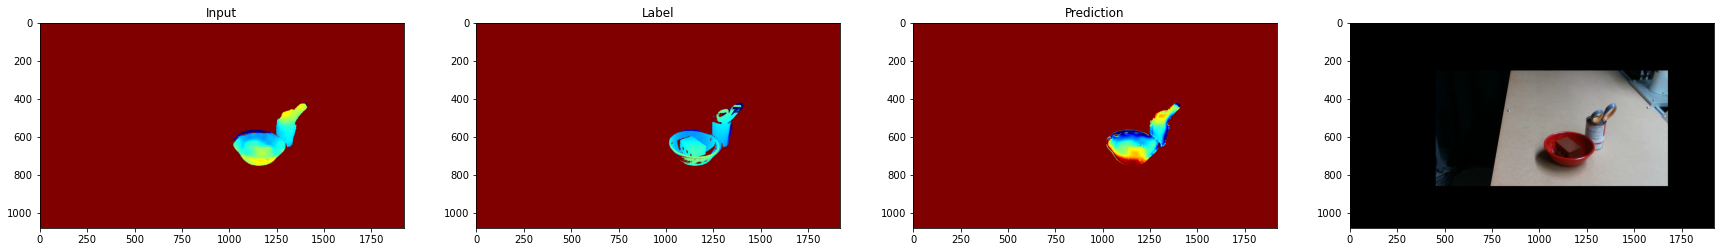

In [11]:
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

logging.info(f'\nPredicting image {files[idx]} ...')

rs_min = np.nanmin(rs_depth)
rs_max = np.nanmax(rs_depth)

set = BasicDataset.preprocess_set(
    rs_rgb, 
    rs_depth, 
    mask, 
    zv_depth, 
    dataset_config
)

img = set['image'].unsqueeze(0)
nan_mask = set['nan-mask'].squeeze().numpy()
region_mask = set['region-mask'].squeeze().numpy()
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad() and torch.cuda.amp.autocast(enabled=network_config['amp']):
    pred_depths = net(img)
    pred_depth = pred_depths.squeeze().float().cpu().detach().numpy()

# resize images to prediction size
input_rgb = BasicDataset.resize(rs_rgb, dataset_config.scale)
# input_depth = BasicDataset.resize(rs_depth, dataset_config.scale)
input_depth = img.numpy().squeeze()[3]
# real_depth = BasicDataset.resize(zv_depth, dataset_config.scale)
real_depth = set['label'].numpy().squeeze()
output_rgb = BasicDataset.resize(zv_rgb, dataset_config.scale)

# undo normalization
if dataset_config.normalize_depths:
    input_depth = unnormalize_depth(input_depth, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)
    pred_depth = unnormalize_depth(pred_depth, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)
    real_depth = unnormalize_depth(real_depth, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)

# blackout pixel not in mask
print(np.nanmin(pred_depth), np.nanmax(pred_depth))
mask = np.logical_and(nan_mask, region_mask)
pred_depth = np.where(mask, pred_depth, np.nan)
input_depth = np.where(mask, input_depth, np.nan)
real_depth = np.where(mask, real_depth, np.nan)

print(f"Mean depths: Input {np.nanmean(input_depth)} Label {np.nanmean(real_depth)} Predicted {np.nanmean(pred_depth)}")
print(f"Distance IT {np.nansum(np.abs(input_depth - real_depth))/ np.sum(mask)}")
print(f"Distance OT {np.nansum(np.abs(pred_depth - real_depth)) / np.sum(mask)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
output_pcd = imgs_to_pcd(output_rgb, real_depth, rs_ci)

o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([output_pcd])
o3d.visualization.draw_geometries([pred_pcd])
o3d.visualization.draw_geometries([input_pcd, output_pcd])
o3d.visualization.draw_geometries([input_pcd, pred_pcd])
o3d.visualization.draw_geometries([pred_pcd, output_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))